# Adaptive noise cancellation demo

 This notebook demonstrates adaptive noise cancellation (ANC) techniques for removing power line interference from signals.
 
 The demo shows how to:
 - Generate synthetic data with power line noise
 - Apply adaptive RLS filtering to cancel the noise
 - Evaluate the filtering performance
 
 The code implements the algorithm described in ["Adaptive cancellation of mains power interference in continuous gravitational wave searches with a hidden Markov model"](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.122004)

 ---
 


## 0. Setup 

In [10]:
# %%
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys 
sys.path.append('../python/')


In [12]:
import numpy as np 
# A useful function for grabbing the spectrum (FT modulus) of a time series, and the associated frequencies
def get_spectrum(data, dt):
    fft_result = np.fft.fft(data)
    N = len(data)
    freq = np.fft.fftfreq(N, d=dt)


    magnitude_spectrum = np.abs(fft_result)

    # Note: The FFT is symmetric for real signals, so often you only want the positive frequencies
    # You can get these by:
    positive_freq = freq[:N//2]
    positive_magnitude = magnitude_spectrum[:N//2]
    
    return  positive_freq,positive_magnitude


---

## 1. Synthetic data 




In [13]:
import numpy as np 
from ANC.generate_synthetic_data import simulate_data
from ANC.hmm_viterbi import viterbi_for_ANC
from ANC.adaptive_filters import arls_n


# Generate simulated data
# The signal measured in the strain channel is x(t) = h(t) + c(t) + n(t)
# where h(t) is the GW signal, c(t) is the non-Gaussian interference, and n(t) is Gaussian noise.
# Separately, the reference signal is r(t) = A_ac * cos(2πf0t + θ(t)) + n_r(t)
# where A_ac is the amplitude of the reference signal, f0 is the central frequency, and θ(t) is the phase noise.
# See the paper for more details.

print("Generating simulated data")

## Sampling parameters 
W = 1000  # Sampling frequency
N = 2**14 # Number of samples per block
T = N/W   # Time within one block
Nb = 64  # Number of frequency blocks for simulated GW signal


## GW parameters 
sigma_f = 1  # Standard deviation of GW frequency
fq      = np.cumsum(np.concatenate(([59.5], sigma_f * np.sqrt(T) * np.random.randn(Nb-1)))) #array of random GW frequencies, see Equation 20 and 21 in paper. Note that the frequency updates are happing at the block level rather than every sample point.
h0      = 0.025   # GW signal amplitude


## Clutter parameters 
gamma_a     = 0.01    # Phase fluctuation parameter (related to 1/P in paper)
A_c         = 1.0    # Amplitude of clutter
sigma_theta = 0.01   # Standard deviation of phase noise (σΘ in paper)
Δfac        = 1.0    # Amplitude of phase modulation 
f_ac        = 60.0 # Hz, central frequency 


## Gaussian noise parameters 
sigma_n     = 1.0    # Standard deviation of Gaussian noise (strain channel)


## Reference signal parameters 
sigma_r     = 1e-2   # Standard deviation of reference signal measurement noise. 
A_r         = 10.0   # Amplitude of the reference 





x, r, injection, time = simulate_data(
                                    f_ac=f_ac,
                                    fq=fq, 
                                    h0=h0,
                                    sigma_n=sigma_n,
                                    W=W,
                                    N=N,
                                    sigma_r=sigma_r,
                                    A_c=A_c,
                                    A_r=A_r,
                                    gamma_a=gamma_a,
                                    Δfac=Δfac,
                                    sigma_theta=sigma_theta
)


# Apply RLS filter
print("Applying RLS filter")
lambda_val = 0.9999999999999999
order = 15
delta_regularization = 1e2
c_RLS, _, _,_= arls_n(x, r, order, lambda_val,delta_regularization) # cancelled, adap, fit, P 


 

Generating simulated data
Applying RLS filter
Applying ARLS filter
Filter order:  15
Number of reference channels:  1


Processing samples: 100%|██████████| 1048576/1048576 [00:09<00:00, 113810.98it/s]


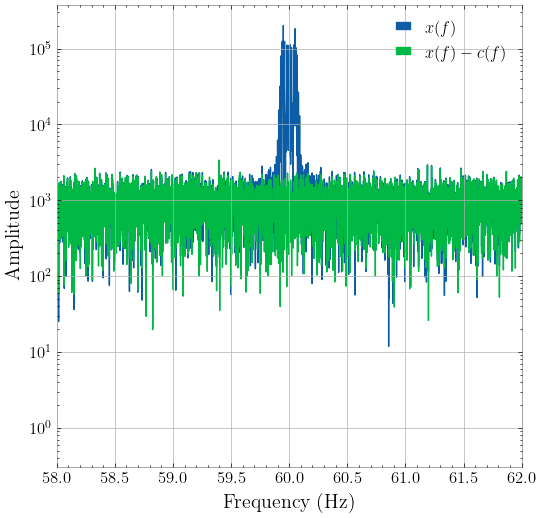

In [14]:
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

dt = time[1]-time[0]
fs = 1/dt

fig_dimension = 6
fig, ax = plt.subplots(figsize=(fig_dimension, fig_dimension))
labels = [r'$x(f)$',r'$x(f) - c(f)$']
for i, s in enumerate([x, c_RLS]):
    positive_freq, positive_magnitude = get_spectrum(s, dt)
    ax.plot(positive_freq, positive_magnitude,label = labels[i])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(58,62)
plt.legend()
plt.yscale('log')


---

## 2. Real LIGO data 


Now lets look at real LIGO data from the actual detector. For this notebook we'll exlusively use publicly available data from the Gravitational Wave Open Science Center (GWOSC) at https://gwosc.org. GWOSC provides open access to LIGO data. We'll use the GWpy package to fetch and analyze this data.


Note that not all of the PEM data is publically available. Here we will use just the 3 channels available from the centtral station (`CS`) `L1:PEM-CS_MAINSMON_EBAY_*_DQ`. For those with LIGO access, the `EX` and `EY`channels can also be used. 


---

### 2.1 There is mains power interference at 60 Hz in the strain channel

To start, lets take a quick look at the spectrum of the strain data in the region of interest. 

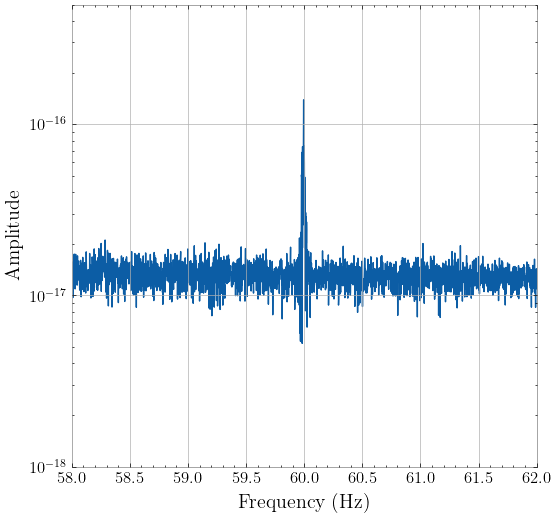

In [15]:
from gwpy.timeseries import TimeSeries

# Time interval
start_time = 1238166208
num_intervals = 10
end_time = start_time + 64*num_intervals

#Fetch the data
strain_data =  TimeSeries.fetch('L1:DCS-CALIB_STRAIN_C01_AR', start=start_time, end=end_time, host='nds.gwosc.org')


# Plot it 
dt = strain_data.dt
f, mag = get_spectrum(strain_data, dt)

#Setup the figure
fig_dimension = 6
fig, ax = plt.subplots(figsize=(fig_dimension, fig_dimension))

#Plot the data
ax.plot(f, mag)

# Config
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(58,62)
plt.ylim(1e-18,5e-16)
plt.yscale('log')


---

### 2.2. The interference is wobbly

It is interesting to note that the mains power interference is not at some fixed frequency, but wanders.

We can look at the ASD of the LIGO-Hanford mains power PEM monitor:

In [16]:
#Get the data
start_time = 1265852907
batchSize = 64*5 #how long a single line is 
numplots = 210  #how many lines we want in the cascade plot

end_time = start_time + batchSize*numplots
hanford_pem   = TimeSeries.get('H1:PEM-CS_MAINSMON_EBAY_1_DQ',start=start_time, end=end_time,host='nds.gwosc.org')

Total length: 68812800, Chunk size: 327680, Chunks: 210
Peak frequencies: 59.9656 Hz to 60.0375 Hz (mean: 60.0078 Hz)
FWHM: 6.16 mHz to 25.48 mHz (mean: 9.84 mHz)


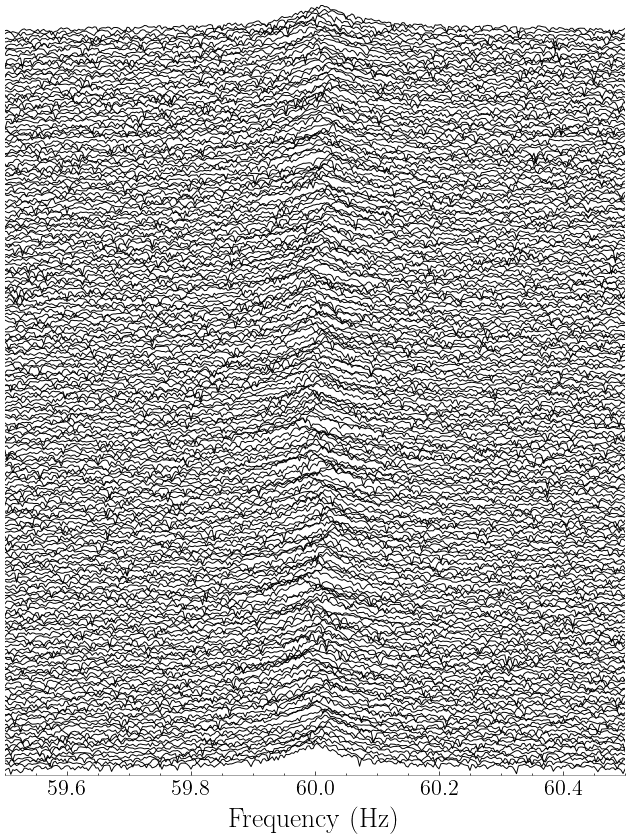

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from scipy.signal import peak_widths
import scienceplots
plt.style.use('science')


# Define frequency range for analysis around 60 Hz power line frequency
FREQ_LOW, FREQ_HIGH = 59.5, 60.5
# Define vertical offset between successive traces in the waterfall plot
SHIFT_PER_TRACE = 0.6

# Calculate parameters for splitting data into chunks
n_chunks = numplots
chunk_size = len(hanford_pem) // n_chunks
dt = hanford_pem.dt
print(f"Total length: {len(hanford_pem)}, Chunk size: {chunk_size}, Chunks: {n_chunks}")

# Create figure
fig, ax = plt.subplots(figsize=(8, 10))

# Lists to store peak frequencies and FWHM values
peaks = []
fwhms = []

# Track min and max y values for plot scaling
ymin = np.inf
ymax = -np.inf

# Process each chunk of data
for i in range(n_chunks):
    # Extract chunk of time series data
    start = i * chunk_size
    end = start + chunk_size
    chunk = hanford_pem[start:end]

    # Calculate amplitude spectral density
    ts = TimeSeries(chunk, dt=dt)
    asd = ts.asd()

    # Focus on frequency range around 60 Hz
    mask = (asd.frequencies.value >= FREQ_LOW) & (asd.frequencies.value <= FREQ_HIGH)
    xs = asd.frequencies.value[mask]
    ys = asd.value[mask]

    # Create waterfall effect by offsetting each trace vertically
    log_ys = np.log10(ys)
    y_offset = log_ys + SHIFT_PER_TRACE * i
    ax.plot(xs, y_offset, color='k', linewidth=0.7)

    # Find peak frequency and calculate FWHM
    idx_peak = np.argmax(ys)
    peak_freq = xs[idx_peak]
    peaks.append(peak_freq)

    # Calculate Full Width at Half Maximum (FWHM)
    results = peak_widths(ys, [idx_peak], rel_height=0.5)
    df = np.diff(xs)[0]
    width_hz = results[0][0] * df * 1e3  # Convert to mHz
    fwhms.append(width_hz)

    # Update plot limits
    ymin = min(ymin, np.min(y_offset))
    ymax = max(ymax, np.max(y_offset))

# Set plot limits to reduce extra whitespace
ax.set_ylim(ymin - 0.1, ymax + 0.1)

# Configure plot aesthetics
ax.set_xlim(FREQ_LOW, FREQ_HIGH)
ax.set_ylim(ymin - 0.1, ymax + 0.1)
ax.set_xlabel('Frequency (Hz)', fontsize=20)
ax.tick_params(axis="both", labelsize=16)
ax.grid(False)

# Remove unnecessary spines
for side in ["top", "right", "left"]:
    ax.spines[side].set_visible(False)

# Remove y-axis ticks since values are arbitrary
ax.set_yticks([])
plt.tick_params(axis='x', which='both', top=False)


# Print summary statistics
print(f"Peak frequencies: {np.min(peaks):.4f} Hz to {np.max(peaks):.4f} Hz (mean: {np.mean(peaks):.4f} Hz)")
print(f"FWHM: {np.min(fwhms):.2f} mHz to {np.max(fwhms):.2f} mHz (mean: {np.mean(fwhms):.2f} mHz)")


---

### 2.3 There is (strong) coherence between strain and PEM reference channels 

To deploy the adaptive noise cancellation techiques, we need there to be a coherence between the strain channel and the PEM reference channels. That is to say, we need the information that is recorded in the PEM channel to be reflected in the strain channel. Indeed, the degree of noise cancellation is [(Equation 4,Elko 1997)](https://ieeexplore.ieee.org/document/625628)


$$ R(f) = \frac{1}{1 - |C_{xy}(f)|^2}$$

Lets look at the coherence between the two channels.

First load the PEM data 

In [18]:
#https://git.ligo.org/gwosc/tutorials/gwosc-aux-tutorials/-/blob/main/Channels/O3_bulk_aux_channel_list.csv
#Only 3 of the MAINSMON channels are available as open data for O3
L1_PEM_CHANNELS = ['L1:PEM-CS_MAINSMON_EBAY_1_DQ', 'L1:PEM-CS_MAINSMON_EBAY_2_DQ', 'L1:PEM-CS_MAINSMON_EBAY_3_DQ']
PEM_data_array = []
start_time = 1238166208
num_intervals = 10
end_time = start_time + 64*num_intervals
for channel in L1_PEM_CHANNELS:
    data = TimeSeries.fetch(channel, start=start_time, end=end_time, host='nds.gwosc.org')
    PEM_data_array.append(data)


The calculate coherence and plot it 

/opt/miniconda3/envs/ANC/lib/python3.10/site-packages/gwpy/signal/spectral/_scipy.py:223: UserWarning: Sampling frequencies are unequal. Higher frequency series will be downsampled before coherence is calculated
  warnings.warn("Sampling frequencies are unequal. Higher "


Text(0.5, 0, 'Frequency [Hz]')

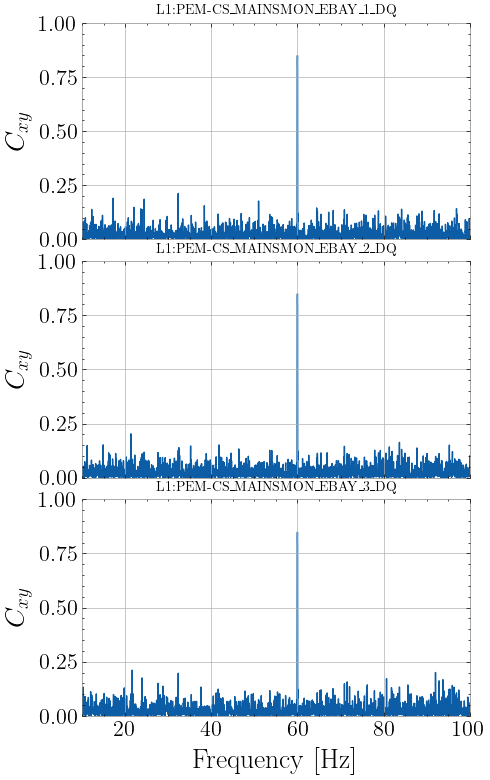

In [19]:
import matplotlib.pyplot as plt
import numpy as np 
import scienceplots
plt.style.use('science')

num_pem_channels = len(L1_PEM_CHANNELS)
fig, axes = plt.subplots(nrows=num_pem_channels, ncols=1, figsize=(5,9),sharex=True)
fs = 20
for i in range(num_pem_channels):

    #Coherence. See e.g. https://gwpy.github.io/docs/latest/examples/frequencyseries/coherence/
    coherence = strain_data.coherence(PEM_data_array[i], fftlength=2, overlap=1)


    #Extract values to give us more flexibility plotting 
    coherence_frequencies = np.array(coherence.frequencies)
    coherence_values = np.array(coherence)


    ax = axes[i]
    ax.plot(coherence_frequencies,coherence_values)


    ax.set_xlim(58, 62)
    ax.set_xlim(10, 100)

    ax.set_ylim(0, 1)

    ax.set_ylabel(r'$C_{xy}$',fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    ax.set_title(L1_PEM_CHANNELS[i],fontsize=fs-10)


#Some extra formatting 
plt.subplots_adjust(hspace=0.1)  
axes[-1].set_xlabel(r'Frequency [Hz]',fontsize=fs)


In [20]:
PEM_data_array[0].dtype

dtype('float32')

There is a clear coherence feature at 60Hz, just where the mains power interference is.

---

### 2.4 We can use ANC to remove the interference, using the PEM

Now lets use the PEM data to filter the 60 Hz clutter from the strain channel.

In [31]:
def run_anc(strain_data, reference,order,lambda_val,delta_regularization):

    ## Run the filter
    cancelled_strain, _, _,_= arls_n(strain_data.value, reference.value, order, lambda_val,delta_regularization) # cancelled, adap, fit, P 


    # Plot the results 
    fig_dimension = 6
    fig, ax = plt.subplots(figsize=(fig_dimension, fig_dimension))




    # Plot the strain data
    strain_freq, strain_magnitude = get_spectrum(strain_data.value, strain_data.dt)
    ax.plot(strain_freq, strain_magnitude,label=r'$x(f)$')


    # Plot the filtered data
    filtered_freq, filtered_magnitude = get_spectrum(cancelled_strain, reference.dt)
    ax.plot(filtered_freq, filtered_magnitude,label=r'$x(f) - \hat{c}(f)$')


    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(58,62)

    plt.legend()
    plt.yscale('log')

For now, lets use just one reference channel. We will look at multiple reference channels later.

Applying ARLS filter
Filter order:  36
Number of reference channels:  1


Processing samples:   0%|          | 0/655360 [00:00<?, ?it/s]

Processing samples: 100%|██████████| 655360/655360 [00:07<00:00, 82007.01it/s]


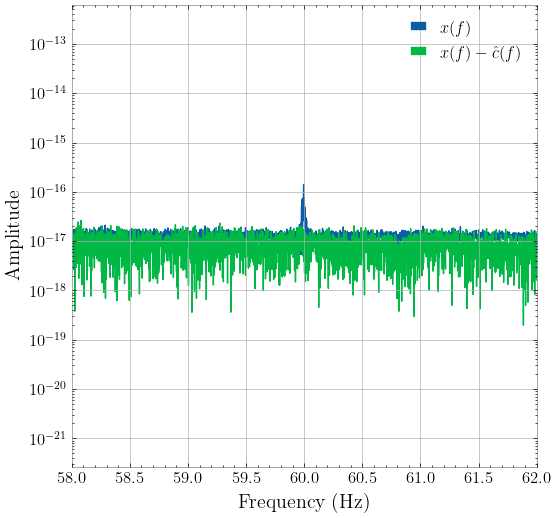

In [32]:
reference = PEM_data_array[0]
## Filter parameters 
lambda_val = 0.99
order = 36
delta_regularization =1e-10 

run_anc(strain_data, reference,order,lambda_val,delta_regularization)



Now lets do the same again, but use all 3 reference channels:

Applying ARLS filter
Filter order:  36
Number of reference channels:  3


Processing samples: 100%|██████████| 655360/655360 [00:46<00:00, 14189.11it/s]


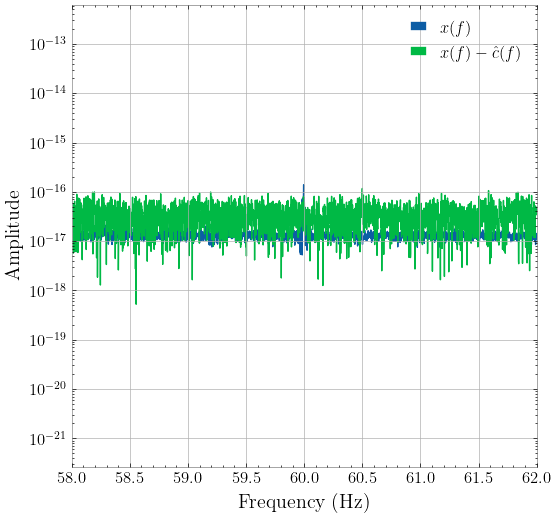

In [33]:
reference = np.vstack(PEM_data_array).T #(Ntimes, Nchannels)

## Filter parameters 
lambda_val = 0.99
order = 36
delta_regularization =1e-10 
run_anc(strain_data, reference,order,lambda_val,delta_regularization)



For multiple reference channels the cancelled signal looks a bit strange. We may need to consider:

* Different filter parameters
* Bandpass to restrict data to frequency region of interest (we are only plotting a narrow range here, but the other frequencies are still there!)
* Normalisation of strain/reference data for numerical stability   
* Allow a burn in phase, discarding the fist $N$ samples. e.g. 
    ```python
        burn_in_samples = int(0.1*len(cancelled_strain))
        filtered_post_burnin = cancelled_strain[burn_in_samples:]
    ```

# Scratch space

In [25]:

# # Evaluate using Viterbi
# print("Evaluating using Viterbi")
# score, _,_ = viterbi_for_ANC(gamma, s, N, Nb, T, W) #score, fhat, y0 
# score_RLS, _,_= viterbi_for_ANC(gamma, c_RLS, N, Nb, T, W)
    